In [386]:
import datetime as dt 
from datetime import datetime,timedelta  # calculating time until expiration
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import numpy as np  # performing numerical methods
import pandas as pd  # printing dataframes
import yfinance as yf # retrieving financial data


In [439]:

# parent/super class
"""
Pricing of stock futures and construction of a portfolio containing both underlying equity
and futures as a hedge.

Attributes
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

ticker: str
    ticker of underlying stock

spot_price: float
    spot price of underlying stock, in united states dollars $

initial_time: str
    current date

final_time: str
    expiration date

dividend: float
    dividend yield, in percentage %, default = 0.00%

risk_tolerance: float
    risk tolerance, in percentage %, default = 0.00%

cap: float
    user capital, in united states dollars $, default = $10,000

shares: float
    user position in underlying stock, in united states dollars $, default = 100 * s
year_time: date
    proportion of diff in time 
liquid: float
    Liquid/capital money (user inputted)
    

"""

class Edward_Dashboard:
    def __init__(self, ticker: str, final_time: str, expected_perf: float, r_tol: float = 0.00, cap: float = 10000, shares: float = 10):
        assert (1 <= len(ticker) <= 5),  'ticker symbol must have between one and five characters'
        assert r_tol >= 0, 'risk tolerance cannot be less than 0.00%'
        assert cap >= 10000,  'user must have at least $10,000 in capital'
        assert shares >= 0.00, 'user must have at least 100 shares in underlying equity'
        self.ticker_symbol = ticker.upper()
        # ticker symbol(user inputted )
        self.ticker = yf.Ticker(ticker.upper()).info
        self.tickerObj =yf.Ticker(ticker.upper())
        # spot price
        s = float(self.ticker['regularMarketPrice'])
        assert s >= 0.00,  'stock price cannot be less than $0.00, cannot use this stock'
        self.spot_price = s
        self.performance = expected_perf
    
        # intial time(not user inputted )
        current_date = datetime.now()
        self.today_time_str = f"{current_date.year}-{current_date.month}-{current_date.day}"
        self.initial_time = datetime.strptime(self.today_time_str, "%Y-%m-%d")
        # final time(user inputted)
        self.final_time = datetime.strptime(final_time, "%Y-%m-%d")
        # porpotion of diff in time
        print(self.final_time- self.initial_time)
        self.year_time = (self.final_time - self.initial_time).days/365
        # risk tolerance
        self.risk_tolerance = float(r_tol)
                # total value of shares (user inputted)
        self.shares = float(shares * self.spot_price)
        #total capital
        self.cap = float(cap)
    def get_historical_data(self):
        temp_csv_str = f"{self.ticker_symbol}.csv"
        temp_csv = self.tickerObj.history(period ="max").to_csv(temp_csv_str)
        new_history_df = pd.read_csv(temp_csv_str)
        historical_data_close= new_history_df[["Date","Close"]]
        return historical_data_close
    def div_rate(self):
        #annual dividend yield
        #this is the dividend rate from the info of the function
        #this is the dividend rate from the most recent year
        dividend_list = self.tickerObj.dividends.to_list()
        if len(dividend_list) != 0:
            return dividend_list[-1] * 4/self.spot_price
        return 0 
        
    def risk_free_rate(self): # calculate risk-free rate of return
        rates = pd.read_csv('rates.csv')

        if 0 < self.year_time <= 1 / 12:
            nominal = rates['1 Mo'].mean()
        elif 1 / 12 < self.year_time <= 1 / 6:
            nominal = rates['2 Mo'].mean()
        elif 1 / 6 < self.year_time <= 1 / 4:
            nominal = rates['3 Mo'].mean()
        elif 1 / 4 < self.year_time <= 1 / 3:
            nominal = rates['4 Mo'].mean()
        elif 1 / 3 < self.year_time <= 1 / 2:
            nominal = rates['6 Mo'].mean()
        elif 1 /  2 < self.year_time <= 1:
            nominal = rates['1 Yr'].mean()
        elif 1 < self.year_time<= 2:
            nominal = rates['2 Yr'].mean()
        elif 2 < self.year_time <= 3:
            nominal = rates['3 Yr'].mean()
        elif 3 < self.year_time <= 5:
            nominal = rates['5 Yr'].mean()
        elif 5 < self.year_time <= 7:
            nominal = rates['7 Yr'].mean()
        elif 7 < self.year_time <= 10:
            nominal = rates['10 Yr'].mean()
        elif 10 < self.year_time <= 20:
            nominal = rates['20 Yr'].mean()
        elif 20 < self.year_time <= 30:
            nominal = rates['30 Yr'].mean()

        return (1 + nominal) / (1 + 0.077) - 1

    def benchmark_rate(self): # calculate performance of a benchmark
        # set the S&P as the default benchmark
        
        #initial time time - (difference)
        days_elapsed = self.final_time - self.initial_time
        beg = self.initial_time -timedelta(days_elapsed.days)
        actual_date = f"{beg.year}-{beg.month}-{beg.day}"        
        hist_table = yf.download('^GSPC', start = actual_date ,end = self.today_time_str )
        hist_table_close = hist_table["Close"]
        print(hist_table_close)
        hist_table_close_list = hist_table_close.to_list()
        final = 1 +(hist_table_close_list[-1] - hist_table_close_list[0])/hist_table_close_list[0]
        return final
        

    def pricing(self,time:float  = 1/52, price: float = .050): # pricing of a singular futures contract on underlying equity
        if self.div_rate() is None:
            div_rate = 0
        else:
            div_rate = self.div_rate()
            
        l = self.risk_free_rate() - div_rate
            
        return price * np.e**(l * time)

    def beta(self): # covariance function
        #get the historical data beginning to end
        end = dt.datetime.now()
        start = dt.date(end.year -5,end.month,end.day)
        tickers = [ self.ticker_symbol,"^GSPC"]
        data = pdr.get_data_yahoo(tickers, start, end, interval = "m")
        data =data["Adj Close"]
        log_returns =np.log(data/data.shift())
        cov =log_returns.cov()
        var =log_returns["^GSPC"].var()
        return cov.loc[self.ticker_symbol,'^GSPC']/var
    def historical_closing_graph(self):
        end = dt.datetime.now()
        start = dt.date(end.year -5,end.month,end.day)
        ticker = self.ticker_symbol
        data = pdr.get_data_yahoo(ticker, start, end, interval = "m")
        print(max(data['Close']))
        plt.figure(figsize=(16,8))
        plt.title('Close Price History')
        plt.plot(data['Close'])
        plt.xlabel('Date',fontsize = 18)
        plt.ylabel('Close Price USD ($)',fontsize = 18)
        plt.show()
    

        
        '''historical_data = self.get_historical_data()
        hist_price = [price for price in historical_data["Close"]]
        future_price = []
        for i in range(len(hist_price)):
            future_price.append(self.pricing(time = 1/52, price = hist_price[i]))
        return np.cov(hist_price,future_price)[0,1]'''
            


    def expected_return(self): # calculate the expected return (w/ respect to a benchmark)
        return float(self.risk_free_rate() + self.beta()*(self.benchmark_rate() - self.risk_free_rate()))

    def Ideal_contractNum(self): # calculate the ideal number of futures contracts on the underlying equity
        return float(self.beta() * self.shares / self.pricing(self.year_time,self.spot_price))

    def portfolio(self): # construct an ideal portfolio, containing the user's existing
        # position in the underlying equity and n futures contracts
        data = [("stock", self.shares / self.spot_price, "$" + str(self.shares)),
    ("futures", self.Ideal_contractNum(), "$" + str(self.Ideal_contractNum() * self.pricing(self.year_time,self.spot_price)))]

        portfolio = pd.DataFrame(data, columns = ["Instrument", " Qty", "Value"])

        return portfolio

    def basis_risk(self): # calculate basis risk of portfolio
        return float(self.spot_price - self.pricing(self.year_time,self.spot_price))

    def metrics(self): # calculate performance & risk metric of portfolio
        sharpe = self.expected_return() * (self.performance - self.benchmark_rate()) / np.std(self.get_historical_data()['Close'])
        alpha = self.performance - self.expected_return()
        risk = np.std(self.get_historical_data()['Close']) ** 2
        risk_difference = risk - self.risk_tolerance

        data = [("sharpe", sharpe), ("alpha", alpha), ("risk", risk), ("risk differential", risk_difference)]

        metrics = pd.DataFrame(data, columns=["Metric", "Value"])

        return metrics
    def _str_(self):
        return f"risk-free-rate{self.risk_free_rate()}, benchmark rate {self.benchmark_rate()}, pricing {self.pricing(self.year_time,self.spot_price)}, beta {self.beta()}, expect_return {self.expected_return()}, number of future contracts (100 share per contract) {self.n()}, protfolio {self.portfolio()}, basis risk {self.basis_risk()}, metrics {self.metrics()}"
        pass



In [440]:
msft= Edward_Dashboard("msft","2022-11-30",.05,r_tol = .05)


3 days, 0:00:00


In [428]:
msft.get_historical_data()

,Date,Close
0,1986-03-13 00:00:00-05:00,0.060809
1,1986-03-14 00:00:00-05:00,0.062980
2,1986-03-17 00:00:00-05:00,0.064067
3,1986-03-18 00:00:00-05:00,0.062437
4,1986-03-19 00:00:00-05:00,0.061351
...,...,...
9248,2022-11-18 00:00:00-05:00,241.220001
9249,2022-11-21 00:00:00-05:00,242.050003
9250,2022-11-22 00:00:00-05:00,245.029999
9251,2022-11-23 00:00:00-05:00,247.580002


In [429]:
msft.basis_risk()

-2.4583113159337415

In [430]:
msft.risk_free_rate()

1.2135393690366656

In [431]:
msft.div_rate()*100

1.0990343044163402

In [432]:
msft.Ideal_contractNum()

9.015447917012576

In [433]:
msft.expected_return()

[*********************100%***********************]  1 of 1 completed
Date
2022-11-25    4026.120117
Name: Close, dtype: float64


1.0191118111949153

In [434]:
msft.portfolio()

,Instrument,Qty,Value
0,stock,10.000000,$2474.9
1,futures,9.015445,$2253.3955208139655


In [435]:
msft.basis_risk()

-2.4583113159337415

In [436]:
msft.pricing(msft.year_time,msft.spot_price)


249.94831131593375

336.32000732421875


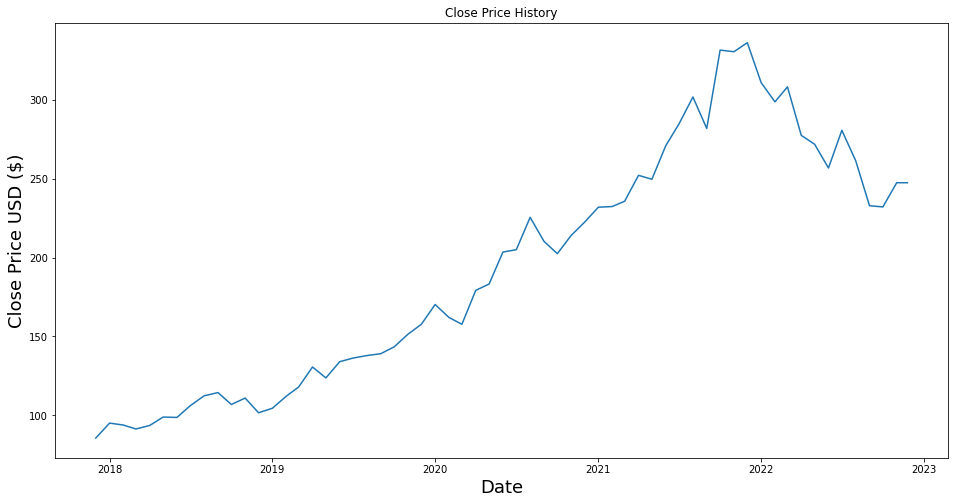

In [437]:
msft.historical_closing_graph()

In [441]:
msft.metrics()

[*********************100%***********************]  1 of 1 completed
Date
2022-11-25    4026.120117
Name: Close, dtype: float64
[*********************100%***********************]  1 of 1 completed
Date
2022-11-25    4026.120117
Name: Close, dtype: float64
[*********************100%***********************]  1 of 1 completed
Date
2022-11-25    4026.120117
Name: Close, dtype: float64


,Metric,Value
0,sharpe,-0.014597
1,alpha,-0.969112
2,risk,4398.948562
3,risk differential,4398.898562
